## Dimentionality Reduction

#### In this notebook we try to find unnecessary features and remove them from data, so the model can train easier and generalize better .

#### So far we have cleaned our data and searched for best possible hyper-parameters. Results are as below:

* Result don't change if we apply standard scaler on all features (OneHotEncoded categories and continuous) or only on continous features
* **RandomForestRegressor** works better than XGBRegressor with this dataset
* Best hyper-parameters: `n_estimators`=150, `max_depth`=None, `min_samples_leaf`=2, max_features=0.5
* Model produces better result when DV is not transformed. So we keep the original target values.
* Best results so far: `MAE`: 1.20551, `R^2`: 0.81978


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# loading libraries
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt
import os
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA, SparsePCA

from transform import TargetTransform   # custom class for handling target value transformation

In [3]:
# setting paths
data_dir = os.path.abspath('./_data')
train_data_fp = os.path.join(data_dir, 'train_clean.csv')
test_data_fp = os.path.join(data_dir, 'test_clean.csv')
data_fp = os.path.join(data_dir, 'data_clean.csv')
os.listdir(data_dir)

['01_EDA.ipynb',
 'data.csv',
 'data.zip',
 'data_clean.csv',
 'data_clean_all_scaled.csv',
 'data_no_missing.csv',
 'Saved-Models',
 'test.csv',
 'test_clean.csv',
 'test_clean_all_scaled.csv',
 'train_clean.csv',
 'train_clean_all_scaled.csv']

In [4]:
# load the training set
train_set = pd.read_csv(train_data_fp)
train_set.head(1)

,ch_type,length,first_or_rerun,episodes_in_season,is_movie,overlaped_with_game,temperature,Is_month_end,Is_month_start,Is_quarter_end,...,Month_12,Dayofweek_0,Dayofweek_1,Dayofweek_2,Dayofweek_3,Dayofweek_4,Dayofweek_5,Dayofweek_6,market_share,market_share_transformed
0,0,0.906181,0,1,0,0,1.094244,0,0,0,...,0,1,0,0,0,0,0,0,0.9,-0.001165


In [5]:
# cut the dependant variable(s) form training set
# target = train_set.loc[:, 'market_share_transformed']
target_src = train_set.loc[:, 'market_share']
# targets_joint = train_set.loc[:, ['market_share_transformed', 'market_share']]

train_set.drop(columns=['market_share', 'market_share_transformed'], inplace=True)

In [6]:
# constant variables for later use
cv = 5    # number of folds for cross-validation
rs = 7    # random-state number

In [7]:
# splitting the train set into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(train_set, target_src, test_size=0.2, random_state=rs)

In [8]:
y_train.head()

117942    0.5
105927    7.1
219211    2.0
526282    1.1
345705    0.2
Name: market_share, dtype: float64

### Helper functions

In [9]:
def get_rf_model(n_estimators=150, max_depth=None, min_samples_leaf=2, max_features=0.5, random_state=rs):
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=random_state)
    return rf

In [10]:
def evaluate(actual, prediction):
    return {'MAE': round(mean_absolute_error(actual, prediction), 5),
            'MSE': round(mean_squared_error(actual, prediction), 5),
            'R^2': round(r2_score(actual, prediction), 5)}

In [11]:
def get_oob_score(X_train, y_train):
    rf = RandomForestRegressor(n_estimators=30, min_samples_leaf=2, max_features=0.5, oob_score=True, n_jobs=-1, random_state=rs)
    rf.fit(X_train, y_train)
    score = rf.oob_score_
    del rf
    return score

In [12]:
get_oob_score(X_train.iloc[:30000], y_train.iloc[:30000])

0.7262147658758434

In [13]:
def get_sample_df(X_train, y_train, n_samples=20000):
    df = pd.concat(objs=[X_train, y_train], axis=1)
    x = df.sample(n=n_samples, axis=0)
    return x.iloc[:, :-1], x.iloc[:, -1]

In [14]:
def plot_feature_importance(fi, labels, figsize=(14, 8)):
    fi = sorted(zip(fi, labels), reverse=True)
    d = d = {k: v for v, k in fi}
    plt.figure(figsize=figsize)
    plt.bar(range(len(d)), list(d.values()), align='center')
    plt.xticks(range(len(d)), list(d.keys()), rotation='vertical')
    plt.show()
    del d

### 1. Get most important features

In [15]:
rf = get_rf_model()

In [16]:
X_sample, y_sample = get_sample_df(X_train, y_train, n_samples=len(X_train)//2)
X_sample.shape, y_sample.shape

((246662, 91), (246662,))

In [17]:
%%time

rf.fit(X_sample, y_sample)

Wall time: 2min 22s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=-1, oob_score=True,
                      random_state=7, verbose=0, warm_start=False)

In [18]:
preds = rf.predict(X_test)

print(rf.oob_score_)
evaluate(y_test, preds)

0.7976582755557806


{'MAE': 1.26508, 'MSE': 4.74396, 'R^2': 0.80426}

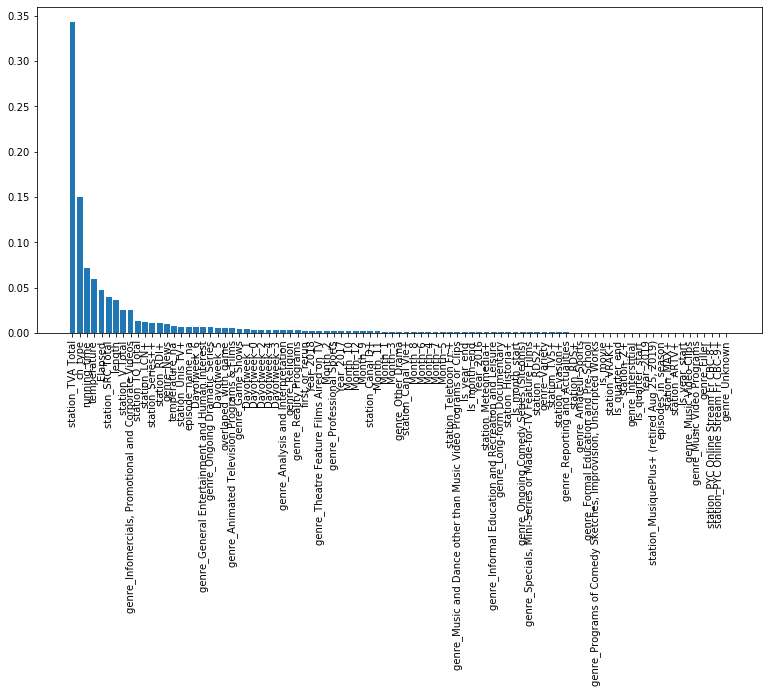

In [19]:
plot_feature_importance(rf.feature_importances_, X_train.columns, figsize=(13, 6))

In [85]:
fi = sorted(zip(rf.feature_importances_, X_train.columns), reverse=True)
to_keep = np.asarray([k for v, k in fi if v > 0.0013])
len(to_keep)

50

In [65]:
X_sample_reduced = X_sample[to_keep]

In [66]:
%%time

rf2 = get_rf_model()
rf2.fit(X_sample_reduced, y_sample)

Wall time: 1min 28s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=-1, oob_score=True,
                      random_state=7, verbose=0, warm_start=False)

In [67]:
preds_reduced = rf2.predict(X_test[to_keep])
print(rf2.oob_score_)
evaluate(y_test, preds_reduced)

0.7878980780486005


{'MAE': 1.32399, 'MSE': 4.98021, 'R^2': 0.79451}

In [88]:
# save extracted columns name to diske for later use
np.savetxt(data_dir + '/to_keep_columns_stage1.txt', to_keep, fmt='%s')

In [70]:
# deleting unnecessary objects to release memory space
del X_sample
del X_sample_reduced
del y_sample

#### Section Summary:
**Since our model performance only dropped slightly, keeping 50 most important features is good enough to continue.**

### 1. PCA

In [17]:
pca = PCA(n_components=None)
pca.fit(X=X_train.values)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [40]:
pca_var = pca.explained_variance_ratio_
pca_var[:10].sum()

0.6300884236077366

In [41]:
pca = PCA(n_components=10)

In [42]:
X_train_dr = pca.fit_transform(X=X_train.values)
X_test_dr = pca.transform(X=X_test.values)

In [43]:
X_train.shape, X_train_dr.shape

((493324, 91), (493324, 10))

In [44]:
X_test.shape, X_test_dr.shape

((123332, 91), (123332, 10))

#### - Evaluate PCA reduced data

In [47]:
# instantiate a RandomForestRegressor object using the researched hyper-parameters
rf = RandomForestRegressor(n_estimators=150, max_depth=None, min_samples_leaf=2, max_features=0.5, n_jobs=-1, random_state=rs, oob_score=True)

In [48]:
%%time
# training the RandomForest model with non-transformed y values
print(time.ctime())
rf.fit(X_train_dr, y_train.iloc[:, 1].values)

Sat Feb 22 00:55:42 2020
Wall time: 5min 15s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

In [49]:
# top 10 most important features for the RandomForest model
sorted(zip(rf.feature_importances_, X_train.columns), reverse=True)[:10]

[(0.40535161040497497, 'temperature'),
 (0.21982713236477797, 'ch_type'),
 (0.08271943796669885, 'overlaped_with_game'),
 (0.07421614770528699, 'is_movie'),
 (0.046469575661957654, 'Is_month_end'),
 (0.04515357395521569, 'episodes_in_season'),
 (0.035972023946313374, 'first_or_rerun'),
 (0.031193040661588053, 'Is_quarter_end'),
 (0.030380885153154295, 'Is_month_start'),
 (0.028716572180032263, 'length')]

In [50]:
# make predictions
rf_preds = rf.predict(X_test_dr)

In [54]:
# evaluating the RandomForest model
evaluate(y_test.iloc[:, 1].values, rf_preds)

{'MAE': 1.4514769000873666,
 'MSE': 6.435371146871701,
 'R^2': 0.7344745436564479}

## 2. SparsePCA

In [56]:
spca = SparsePCA(n_components=10, random_state=rs)

In [57]:
X_train_sdr = spca.fit_transform(X=X_train.values)
X_test_sdr = spca.transform(X=X_test.values)

In [58]:
X_train.shape, X_train_sdr.shape

((493324, 91), (493324, 10))

In [59]:
# instantiate a RandomForestRegressor object using the researched hyper-parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=30, n_jobs=-1, random_state=rs)

In [60]:
%%time
# training the RandomForest model with non-transformed y values
print(time.ctime())
rf.fit(X_train_sdr, y_train.iloc[:, 1].values)

Sat Feb 22 01:46:18 2020
Wall time: 5min 27s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

In [61]:
# top 10 most important features for the RandomForest model
sorted(zip(rf.feature_importances_, X_train.columns), reverse=True)[:10]

[(0.4553702704232678, 'temperature'),
 (0.19889021036921006, 'ch_type'),
 (0.102520397123655, 'overlaped_with_game'),
 (0.06183333057032992, 'is_movie'),
 (0.052246417659769624, 'Is_month_end'),
 (0.034886186825477845, 'first_or_rerun'),
 (0.028156347711736685, 'episodes_in_season'),
 (0.02420950418344279, 'length'),
 (0.02207324690571624, 'Is_quarter_end'),
 (0.019814088227394017, 'Is_month_start')]

In [62]:
# make predictions
rf_preds = rf.predict(X_test_sdr)

In [63]:
# evaluating the RandomForest model
evaluate(y_test.iloc[:, 1].values, rf_preds)

{'MAE': 1.2693409352681773,
 'MSE': 4.949469472597897,
 'R^2': 0.7957833184168581}